In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

In [6]:
days_to_p0 = (lockdown_time - p0_time).days
# print('lockdown date',  assumed_ld_date)
params = Params(
    total_population=params_before.total_population,
    initial_num_E=params_before.initial_num_E,
    initial_num_I=params_before.initial_num_I,
    initial_num_M=params_before.initial_num_M,    
    alpha=[(0, params_before.alpha), (days_to_p0, params_after.alpha)],
    beta=[(0, params_before.beta), (days_to_p0, params_after.beta)],
    mu_ei=params_before.mu_ei,
    x0_pt=params_before.x0_pt,
    k_pt=params_before.k_pt,
    mu_mo=params_before.mu_mo,
    k_days=params_before.k_days
)

In [7]:
def one_run(bed_number_factor, total_days=360):
    updated_bed_info = [(t, n*bed_number_factor) for (t, n) in bed_info]
    total, _, _, _ = do_simulation(total_days, updated_bed_info, params, verbose=0)    
    return bed_number_factor, total

In [10]:
total_days = 360

In [11]:
rows = Parallel(n_jobs=-1)(
    delayed(one_run)(factor, total_days)
    for  factor in np.arange(0.5, 3.1, step=0.5)
)

0.5
1.0
1.5
2.0
2.5
3.0


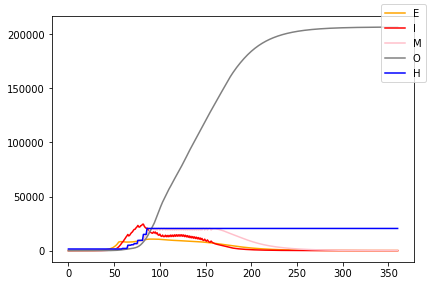

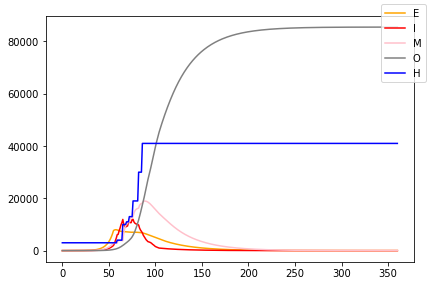

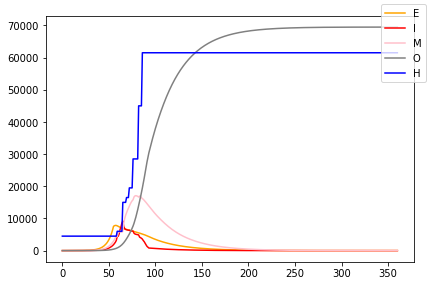

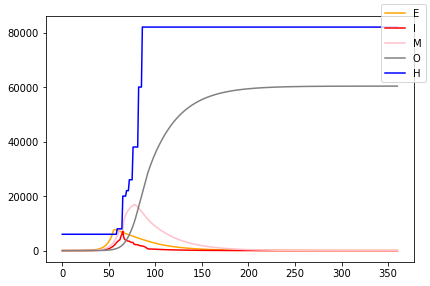

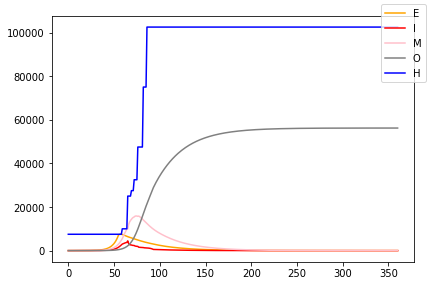

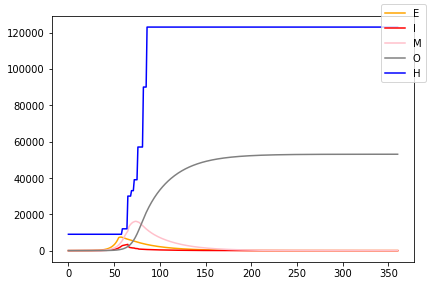

In [14]:
for factor, total in rows:
    print(factor)
    fig, ax = plot_total(total)
    fig.savefig(f'figs/bed-number/{factor}.pdf')
    
    total_to_csv(p0_time, total_days, total, f'output/tbl/bed-number/{factor}.csv')